<a href="https://colab.research.google.com/github/Ramesh-Arvind/BP-Estimation-using-CNN/blob/main/Absenteesim_at_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import yeojohnson

In [2]:
data = pd.read_csv("/content/Absenteeism_at_work.csv", sep=";")
print(f"Dimensionality of data: {data.shape}")

for col in data.columns:
    print(f"Column: {col:35} | type: {str(data[col].dtype):7} | missing_values: {data[col].isna().sum():3d}")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(data.describe().T)


Dimensionality of data: (740, 21)
Column: ID                                  | type: int64   | missing_values:   0
Column: Reason for absence                  | type: int64   | missing_values:   0
Column: Month of absence                    | type: int64   | missing_values:   0
Column: Day of the week                     | type: int64   | missing_values:   0
Column: Seasons                             | type: int64   | missing_values:   0
Column: Transportation expense              | type: int64   | missing_values:   0
Column: Distance from Residence to Work     | type: int64   | missing_values:   0
Column: Service time                        | type: int64   | missing_values:   0
Column: Age                                 | type: int64   | missing_values:   0
Column: Work load Average/day               | type: float64 | missing_values:   0
Column: Hit target                          | type: int64   | missing_values:   0
Column: Disciplinary failure                | type: int64   | mi

In [3]:
# Some of them are categorical attributes we are going to change it from numerical to categorical attributes
month_encoding = {0: 'Unknown', 1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
                  8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
week_encoding = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}
seasonal_encoding = {1: 'Spring', 2: 'Summer', 3: "Fall", 4: "Winter"}
educational_encoding = {1: "high_school", 2: "graduate", 3: "postgraduate", 4: "master_phd"}
yes_no_encoding = {0: "No", 1: "Yes"}

preprocessed_data = data.copy()

preprocessed_data["Month of absence"] = preprocessed_data["Month of absence"].apply(lambda x: month_encoding[x])
preprocessed_data["Day of the week"] = preprocessed_data["Day of the week"].apply(lambda x: week_encoding[x])
preprocessed_data["Seasons"] = preprocessed_data["Seasons"].apply(lambda x: seasonal_encoding[x])
preprocessed_data["Education"] = preprocessed_data["Education"].apply(lambda x: educational_encoding[x])
preprocessed_data["Disciplinary failure"] = preprocessed_data["Disciplinary failure"].apply(
    lambda x: yes_no_encoding[x])
preprocessed_data["Social drinker"] = preprocessed_data["Social drinker"].apply(lambda x: yes_no_encoding[x])
preprocessed_data["Social smoker"] = preprocessed_data["Social smoker"].apply(lambda x: yes_no_encoding[x])

print(preprocessed_data.head().T)


                                           0            1            2  \
ID                                        11           36            3   
Reason for absence                        26            0           23   
Month of absence                        July         July         July   
Day of the week                      Tuesday      Tuesday    Wednesday   
Seasons                               Spring       Spring       Spring   
Transportation expense                   289          118          179   
Distance from Residence to Work           36           13           51   
Service time                              13           18           18   
Age                                       33           50           38   
Work load Average/day                239.554      239.554      239.554   
Hit target                                97           97           97   
Disciplinary failure                      No          Yes           No   
Education                        high_

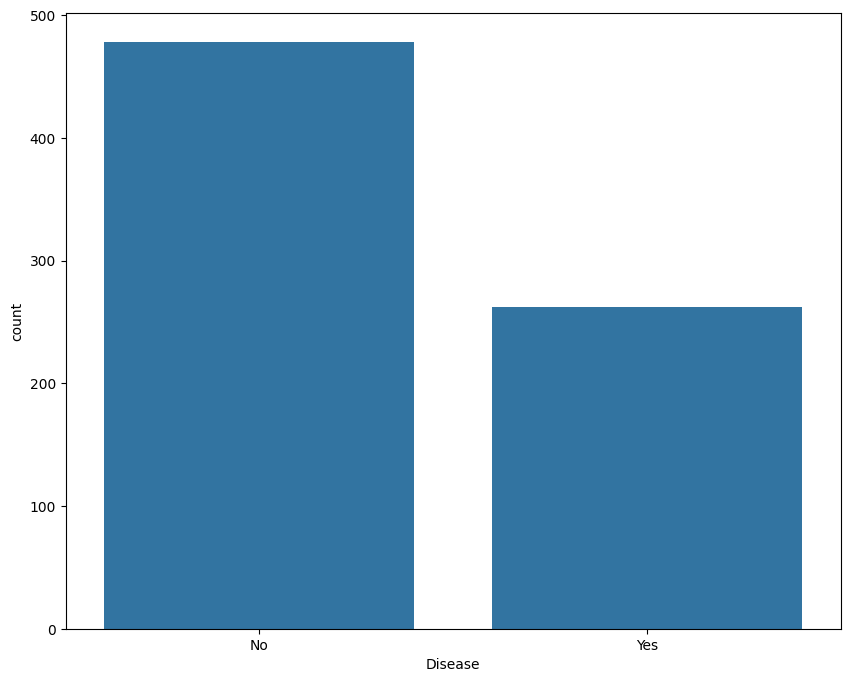

In [4]:
def icd(val):
    return "Yes" if val >= 1 and val <= 21 else "No"

preprocessed_data["Disease"] = preprocessed_data["Reason for absence"].apply(icd)

plt.figure(figsize=(10, 8))
sns.countplot(preprocessed_data, x="Disease")
plt.show()


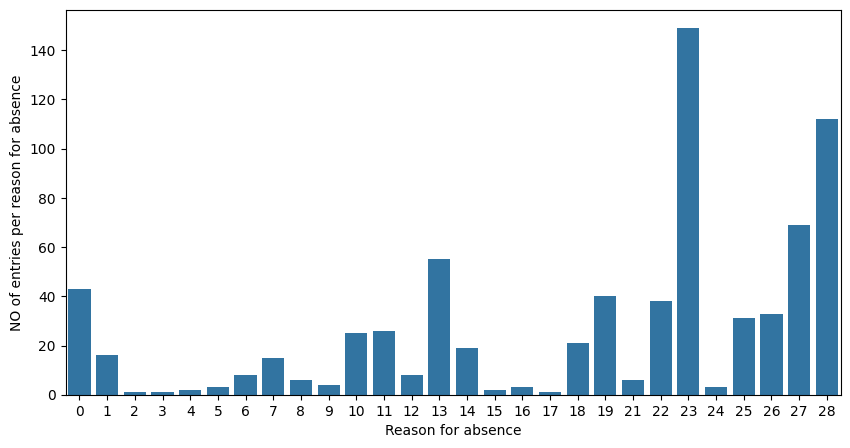

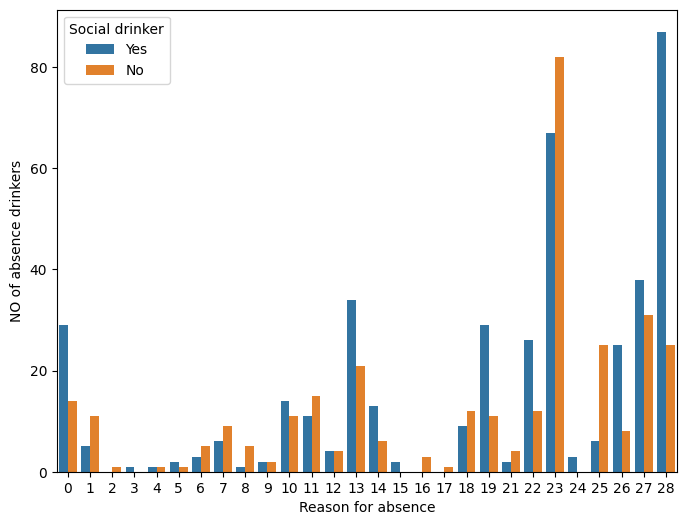

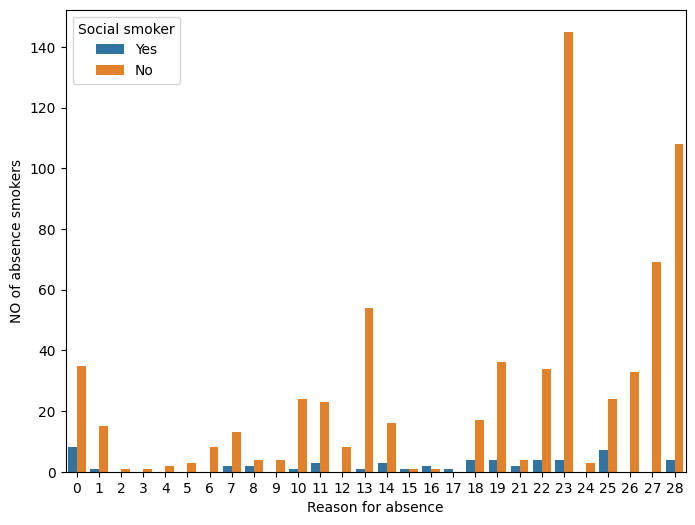

Yes    0.567568
No     0.432432
Name: Social drinker, dtype: float64
No     0.927027
Yes    0.072973
Name: Social smoker, dtype: float64


In [5]:
# Initial analysis for absentism as the no category is more:

plt.figure(figsize=(10, 5))
ax = sns.countplot(preprocessed_data, x="Reason for absence")
ax.set_ylabel("NO of entries per reason for absence")
plt.show()

# Analysis of smoking and drinking that impacted for absentism at work
plt.figure(figsize=(8, 6))
ax = sns.countplot(preprocessed_data, x="Reason for absence", hue="Social drinker", hue_order=["Yes", "No"])
ax.set_ylabel("NO of absence drinkers")
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.countplot(preprocessed_data, x="Reason for absence", hue="Social smoker", hue_order=["Yes", "No"])
ax.set_ylabel("NO of absence smokers")
plt.show()

print(preprocessed_data["Social drinker"].value_counts(normalize=True))
print(preprocessed_data["Social smoker"].value_counts(normalize=True))

P(Social drinker) = 0.568 | P(Social smoker) = 0.073


<Figure size 640x480 with 0 Axes>

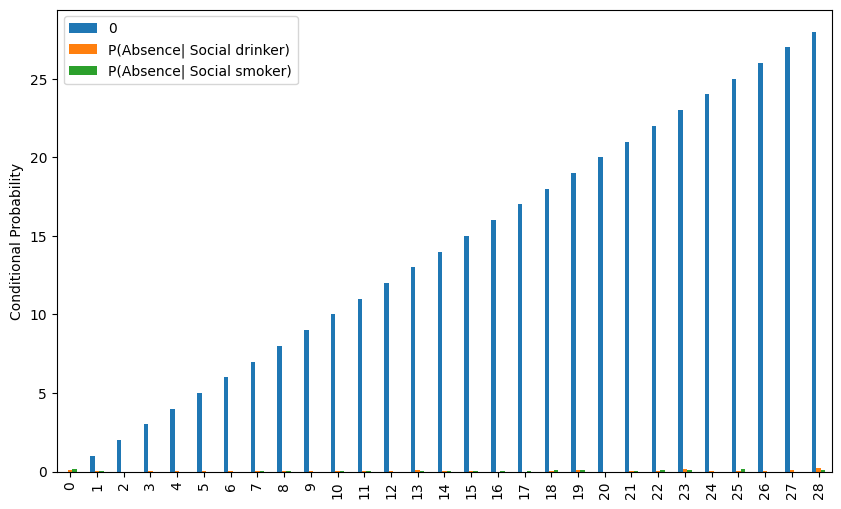

In [6]:
# Hard to say whether there is a relationship between the absence reasons and smoking
# Conditional Property
drinker_prob = preprocessed_data["Social drinker"].value_counts(normalize=True)["Yes"]
smoker_prob = preprocessed_data["Social smoker"]. value_counts(normalize=True)["Yes"]
print(f"P(Social drinker) = {drinker_prob:.3f} | P(Social smoker) = {smoker_prob:.3f}")

# Drinker is 57% and smoker is 7.3%

#Probabiity of being social drinker/smoker for absent for each reason
drinker_mask = preprocessed_data["Social drinker"] =="Yes"
smoker_mask = preprocessed_data["Social smoker"] =="Yes"

total_entries = preprocessed_data.shape[0]
absence_drinker_prob = preprocessed_data["Reason for absence"][drinker_mask].value_counts() / total_entries
absence_smoker_prob = preprocessed_data["Reason for absence"][smoker_mask]. value_counts() / total_entries

# Conditional probablilty
cond_prob = pd.DataFrame(range(0,29))
cond_prob["P(Absence| Social drinker)"] = absence_drinker_prob/drinker_prob
cond_prob["P(Absence| Social smoker)"] = absence_smoker_prob/smoker_prob

plt.figure()
ax = cond_prob.plot.bar(figsize=(10,6))
ax.set_ylabel("Conditional Probability")
plt.show()

THe highest reason for absence for drinkers is dental consulting and medical examinations

The highest reason for absence for smokers is unknown reason and laboratory examinations


<Figure size 640x480 with 0 Axes>

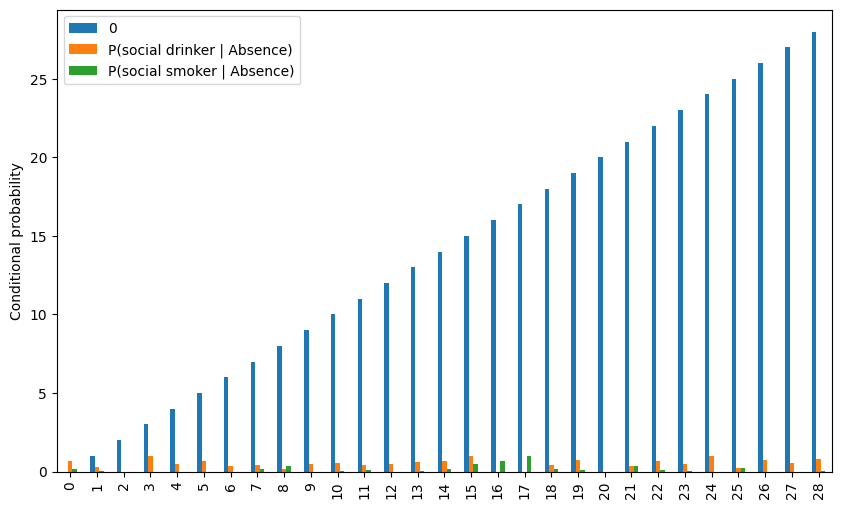

In [7]:
absence_prob = preprocessed_data["Reason for absence"].value_counts(normalize=True)
cond_prob_drinker_smoker = pd.DataFrame(range(0,29))
cond_prob_drinker_smoker["P(social drinker | Absence)"] = cond_prob["P(Absence| Social drinker)"] * drinker_prob/absence_prob
cond_prob_drinker_smoker["P(social smoker | Absence)"] = cond_prob["P(Absence| Social smoker)"] * smoker_prob/absence_prob
plt.figure()
ax= cond_prob_drinker_smoker.plot.bar(figsize=(10,6))
ax.set_ylabel("Conditional probability")
plt.show()

The above graph didn't give the information properly that is due to the smaller dataset


<ipython-input-8-5e77525c06e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Social drinker", y="Absenteeism time in hours", data=preprocessed_data, order=["No", "Yes"],palette="Set2")


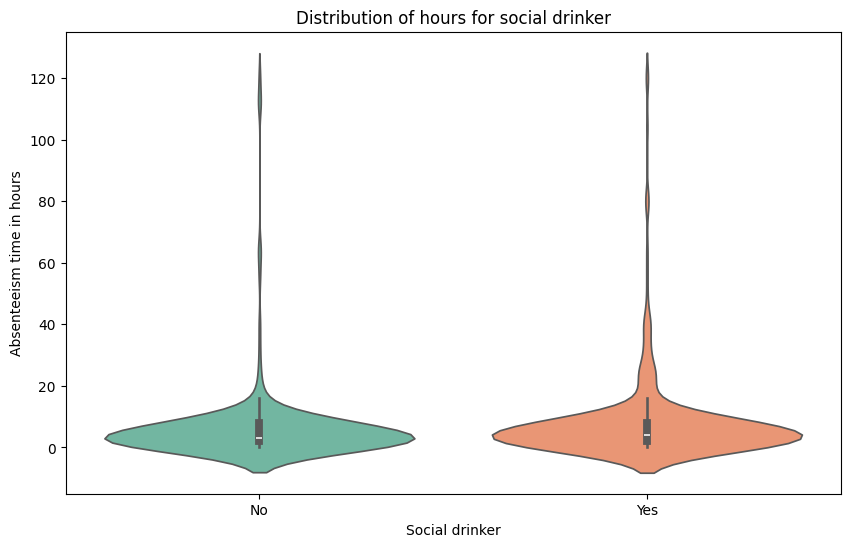

<ipython-input-8-5e77525c06e5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Social smoker", y="Absenteeism time in hours", data=preprocessed_data, order=["No", "Yes"],palette="Set2")


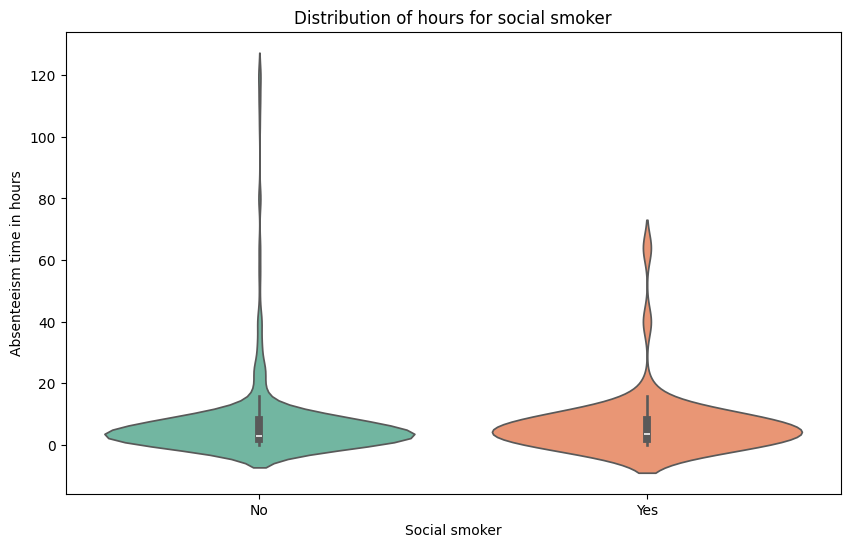

In [8]:

# Analyse the distribution of hours of absentism based on two classes
plt.figure(figsize=(10,6))
sns.violinplot(x="Social drinker", y="Absenteeism time in hours", data=preprocessed_data, order=["No", "Yes"],palette="Set2")
plt.title("Distribution of hours for social drinker")
plt.show()

# distribution of hours of absentism based on two classes
plt.figure(figsize=(10,6))
sns.violinplot(x="Social smoker", y="Absenteeism time in hours", data=preprocessed_data, order=["No", "Yes"],palette="Set2")
plt.title("Distribution of hours for social smoker")
plt.show()


In [9]:

# Hypothesis Testing
# The average absentism hours is same for drinkers and non drinkers
hours_col = "Absenteeism time in hours"
hours_drinkers = preprocessed_data.loc[drinker_mask, hours_col]
hours_non_drinkers = preprocessed_data.loc[~drinker_mask, hours_col]
drinkers_test = ttest_ind(hours_drinkers, hours_non_drinkers)
print(f"Statistic value: {drinkers_test[0]}, p-value: {drinkers_test[1]}")

hours_smoker = preprocessed_data.loc[smoker_mask,hours_col]
hours_non_smoker = preprocessed_data.loc[~smoker_mask, hours_col]
smokers_test = ttest_ind(hours_smoker,hours_non_smoker)
print(f"Statistic value: {smokers_test[0]}, p-value: {smokers_test[1]}")


Statistic value: 1.7713833295243993, p-value: 0.07690961828294651
Statistic value: -0.24277795417700243, p-value: 0.8082448720154971


The p-value of both tests is above the critical value of 0.05, which means that we cannot reject the null hypothesis. In other words, we cannot say that there is a statistically significant difference in the absenteeism hours between drinkers (and smokers) and non-drinkers (and non-smokers)


In [10]:

# Checking the difference of distribution
ks_drinkers = ks_2samp(hours_drinkers, hours_non_drinkers)
ks_smokers = ks_2samp(hours_smoker,hours_non_smoker)
print(f"Drinkers comparison: statistics={ks_drinkers[0]:.3f}, pvalue={ks_drinkers[1]:.3f}")
print(f"Smokers comparison: statistics={ks_smokers[0]:.3f}, pvalue={ks_smokers[1]:.3f}")


Drinkers comparison: statistics=0.135, pvalue=0.002
Smokers comparison: statistics=0.104, pvalue=0.607


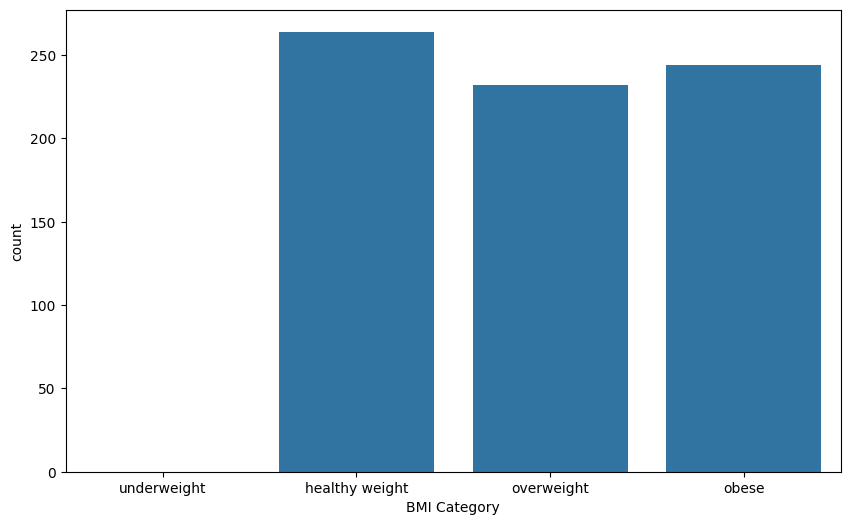

<ipython-input-11-8528f438148b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="BMI Category", y="Absenteeism time in hours", data=preprocessed_data, order=["healthy weight", "overweight", "obese"], palette="Set2")


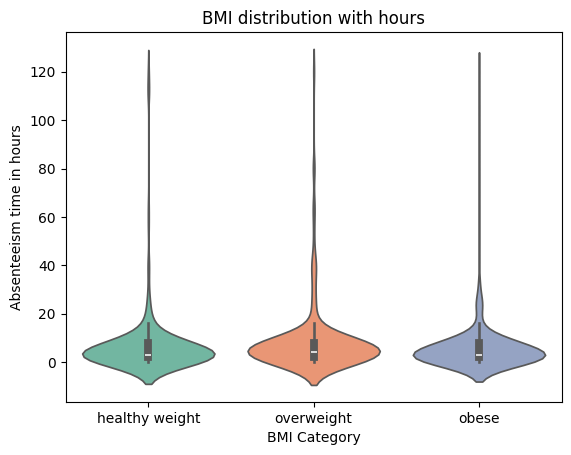

In [11]:

# Comparison with bmi
def get_bmi_category(bmi):
    if bmi < 18.5:
        category = "underweight"
    elif bmi >= 18.5 and bmi < 25:
        category = "healthy weight"
    elif bmi >= 25 and bmi < 30:
        category = "overweight"
    else:
        category = "obese"
    return category

preprocessed_data["BMI Category"] = preprocessed_data["Body mass index"].apply(get_bmi_category)


# Count each category
plt.figure(figsize=(10,6))
sns.countplot(data=preprocessed_data, x="BMI Category", order=["underweight", "healthy weight", "overweight", "obese"])
plt.show()


# Distribution of classes with absentism in hours
sns.violinplot(x="BMI Category", y="Absenteeism time in hours", data=preprocessed_data, order=["healthy weight", "overweight", "obese"], palette="Set2")
plt.title("BMI distribution with hours")
plt.show()



No significance difference with bmi indicator for absenteeism in hours


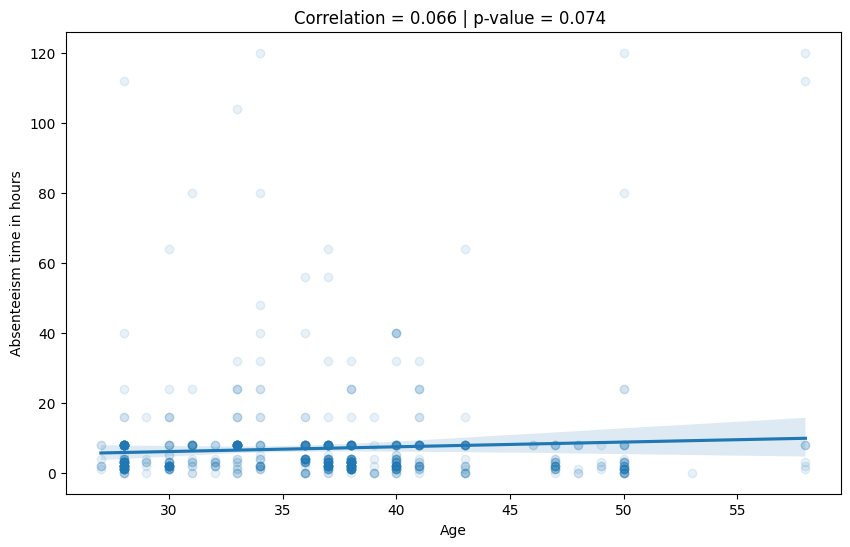

In [13]:
# Will proceed with any age related factors is part of absenteeism in hours
# Will do the corelation among age and absenteeism in hours

pearson_Age_hours = pearsonr(preprocessed_data['Age'], preprocessed_data['Absenteeism time in hours'])
plt.figure(figsize=(10,6))
ax = sns.regplot(x="Age", y="Absenteeism time in hours", data=preprocessed_data, scatter_kws={"alpha":0.1})
ax.set_title(f"Correlation = {pearson_Age_hours[0]:.03f} | p-value = {pearson_Age_hours[1]:.03f} ")
plt.show()


We can observe the correaltion is too small 0.066 and p-value is more than 0.05, It shows there is not a relationship between the age and absenteeism in hour


<ipython-input-14-81adccec7591>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Disease", y="Age", data=preprocessed_data,palette="Set2")


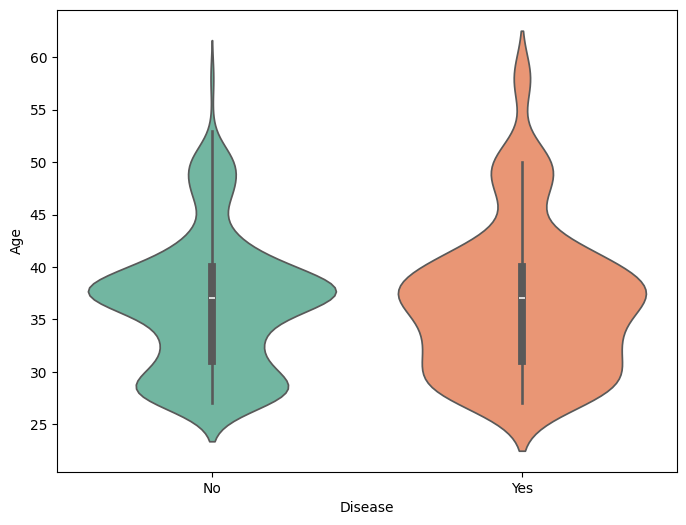

In [14]:
# Now we can compare the age factor with disease to see if there is any relation
plt.figure(figsize=(8,6))
sns.violinplot(x="Disease", y="Age", data=preprocessed_data,palette="Set2")
plt.show()

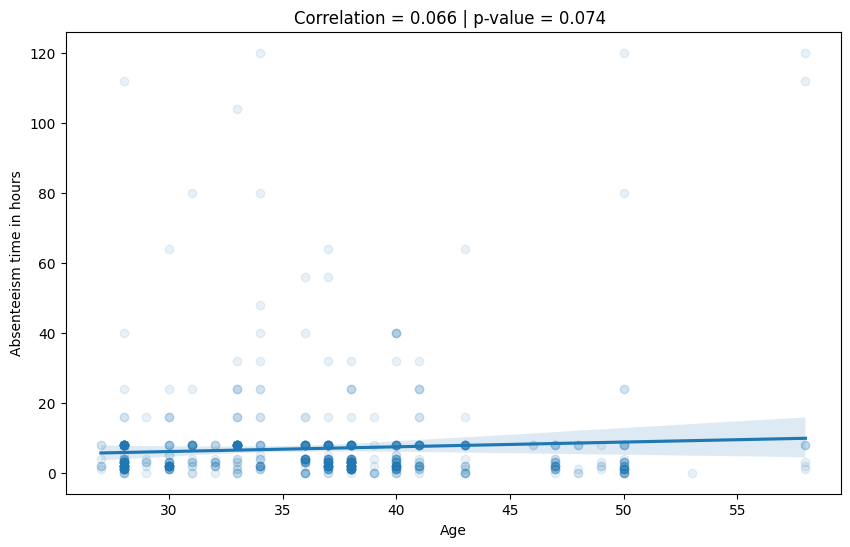

In [15]:
# Will proceed with any age related factors is part of absenteeism in hours
# Will do the corelation among age and absenteeism in hours

pearson_Age_hours = pearsonr(preprocessed_data['Age'], preprocessed_data['Absenteeism time in hours'])
plt.figure(figsize=(10,6))
ax = sns.regplot(x="Age", y="Absenteeism time in hours", data=preprocessed_data, scatter_kws={"alpha":0.1})
ax.set_title(f"Correlation = {pearson_Age_hours[0]:.03f} | p-value = {pearson_Age_hours[1]:.03f} ")
plt.show()



We can observe the correaltion is too small 0.066 and p-value is more than 0.05, It shows there is not a relationship between the age and absenteeism in hour


<ipython-input-16-1486dfd38b89>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Disease", y="Age", data=preprocessed_data,palette="Set2")


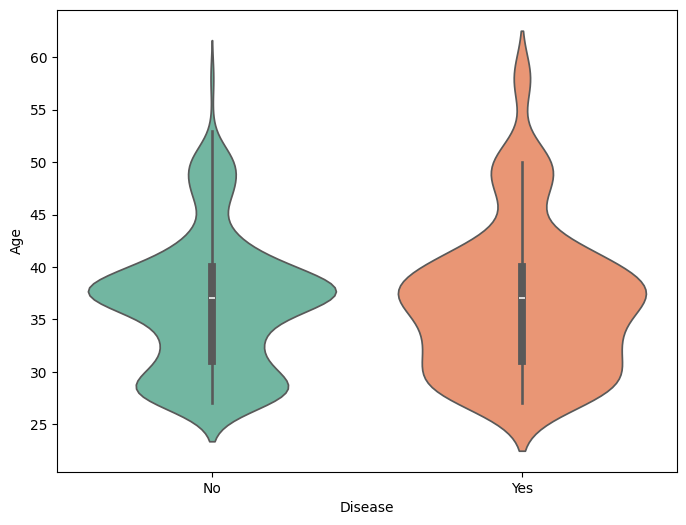

Statistics test: 0.630, p-value: 0.529
Equality of distribution: Statistics: 0.057, p-value: 0.619


In [16]:
# Now we can compare the age factor with disease to see if there is any relation
plt.figure(figsize=(8,6))
sns.violinplot(x="Disease", y="Age", data=preprocessed_data,palette="Set2")
plt.show()

# Based on the above figure, we can able to look that age above 50 has some class distribution, to analyse more we use hypothesis testing
disease_mask = preprocessed_data["Disease"] == "Yes"
age_disease = preprocessed_data["Age"][disease_mask]
no_age_disease = preprocessed_data["Age"][~disease_mask]

test_res = ttest_ind(age_disease,no_age_disease)
print(f"Statistics test: {test_res[0]:.03f}, p-value: {test_res[1]:.03f}")

# Testing equality of distribution
kk_res = ks_2samp(age_disease,no_age_disease)
print(f"Equality of distribution: Statistics: {kk_res[0]:.03f}, p-value: {kk_res[1]:.03f}")


We can conclude that age has no impact on the absenteeism

Education type: high_school  | counts:   611 | percentages: 82.6
Education type: graduate     | counts:    46 | percentages:  6.2
Education type: postgraduate | counts:    79 | percentages: 10.7
Education type: master_phd   | counts:     4 | percentages:  0.5


<ipython-input-17-492c1b979089>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Education", y="Absenteeism time in hours",


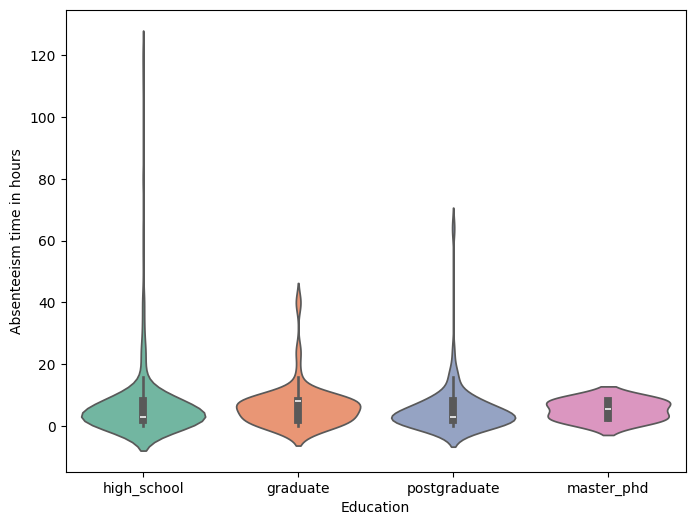

In [17]:
#Now we compare with education impact in abseentism

education_type = ["high_school", "graduate", "postgraduate", "master_phd"]
counts = preprocessed_data["Education"].value_counts()
percentage = preprocessed_data["Education"].value_counts(normalize=True)
for educ_type in education_type:
    print(f"Education type: {educ_type:12s} | counts:{counts[educ_type]:6.0f} | percentages: {100* percentage[educ_type]:4.1f}")

plt.figure(figsize=(8,6))
sns.violinplot(x="Education", y="Absenteeism time in hours",
               data=preprocessed_data,
               order=["high_school", "graduate",
                      "postgraduate", "master_phd"], palette="Set2")
plt.show()





At most of the employees in the data have a high school degree (82.6%), which means that the data is highly biased toward these employees distribution of absence hours, based on education level

In [18]:
threshold = 40
total_entries = len(preprocessed_data)
high_school_mask = preprocessed_data["Education"] == "high_school"
extreme_mask = preprocessed_data["Absenteeism time in hours"] > threshold
prob_high_school = len(preprocessed_data[high_school_mask]) /total_entries
prob_graduate = len(preprocessed_data[~high_school_mask])/total_entries

"""compute probability of having high school and being absent for more than "threshold" hours
"""
prob_extreme_high_school = len(preprocessed_data[high_school_mask & extreme_mask]) /total_entries

"""compute probability of having more than high school and being absent for more than "threshold" hours
"""
prob_extreme_graduate = len(preprocessed_data[~high_school_mask & extreme_mask])/total_entries

# compute and print conditional probabilities
cond_prob_extreme_high_school = prob_extreme_high_school \
                                /prob_high_school
cond_prob_extreme_graduate = prob_extreme_graduate/prob_graduate
print(f"P(extreme absence | degree = high_school) = {100*cond_prob_extreme_high_school:3.2f}")
print(f"P(extreme absence | degree != high_school) = {100*cond_prob_extreme_graduate:3.2f}")
print(preprocessed_data.head().T)

P(extreme absence | degree = high_school) = 2.29
P(extreme absence | degree != high_school) = 0.78
                                           0            1            2  \
ID                                        11           36            3   
Reason for absence                        26            0           23   
Month of absence                        July         July         July   
Day of the week                      Tuesday      Tuesday    Wednesday   
Seasons                               Spring       Spring       Spring   
Transportation expense                   289          118          179   
Distance from Residence to Work           36           13           51   
Service time                              13           18           18   
Age                                       33           50           38   
Work load Average/day                239.554      239.554      239.554   
Hit target                                97           97           97   
Disciplinary 

<Figure size 1000x600 with 0 Axes>

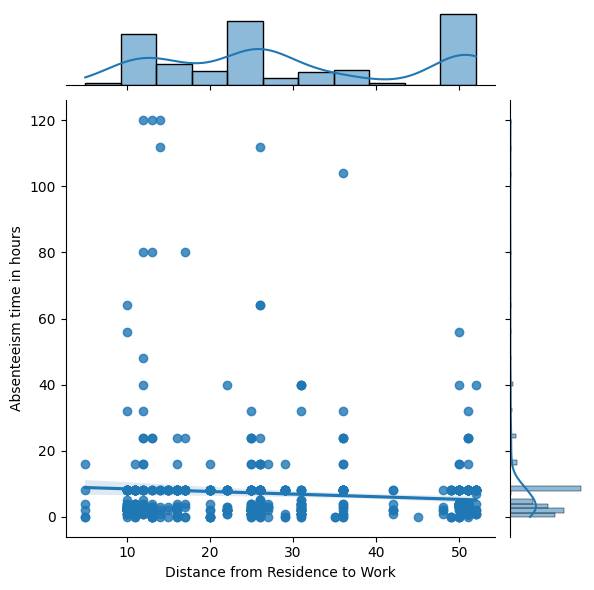

<Figure size 1000x600 with 0 Axes>

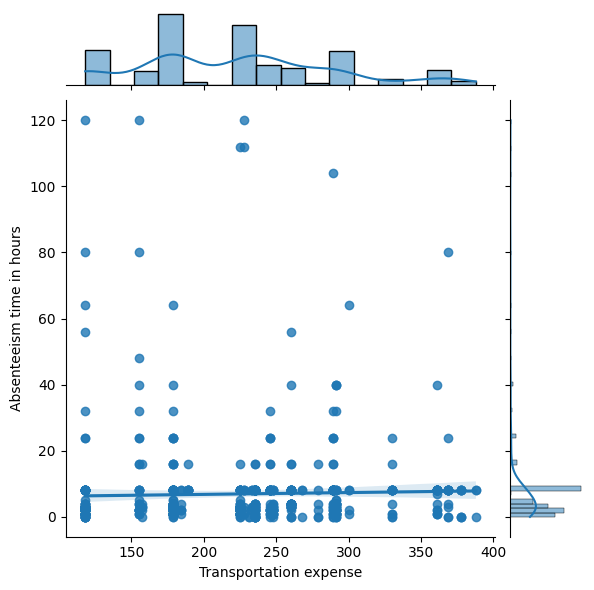

In [19]:
# Now we compare with work and Transportation cost to absenteeism in hours
plt.figure(figsize=(10,6))
sns.jointplot(x="Distance from Residence to Work", y="Absenteeism time in hours", data=preprocessed_data, kind="reg")
plt.show()

plt.figure(figsize=(10,6))
sns.jointplot(x="Transportation expense", y="Absenteeism time in hours", data=preprocessed_data, kind="reg")
plt.show()


Based on the analysis distance form residence to work follows a normal distribution but the transport expense is rightly skewed, we cant able to interpret properly. we need to convert into normal distribution using box cox or yeo-johnson

Since abseentism in hours may contain zeros, we will use the yeo johnson, we cant use box cox because it fails the transformation when it has zeroes or negative values.


<Figure size 800x600 with 0 Axes>

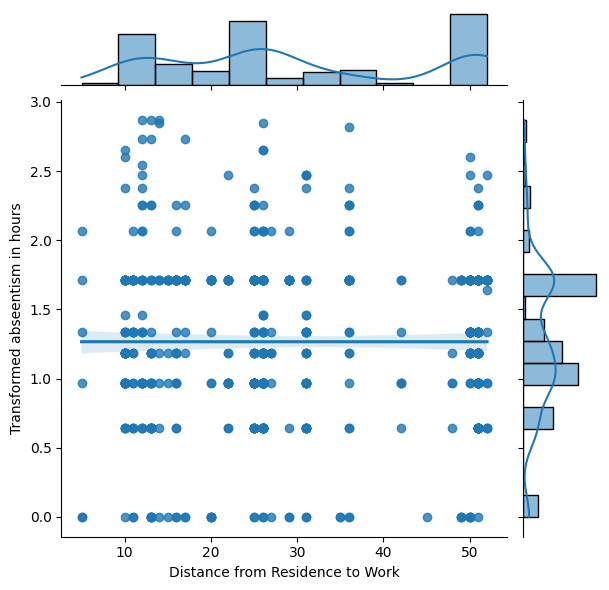

<Figure size 800x600 with 0 Axes>

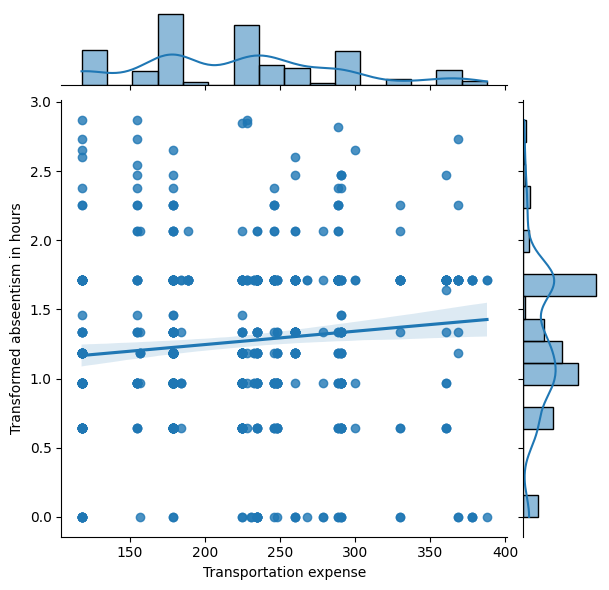

<Figure size 800x600 with 0 Axes>

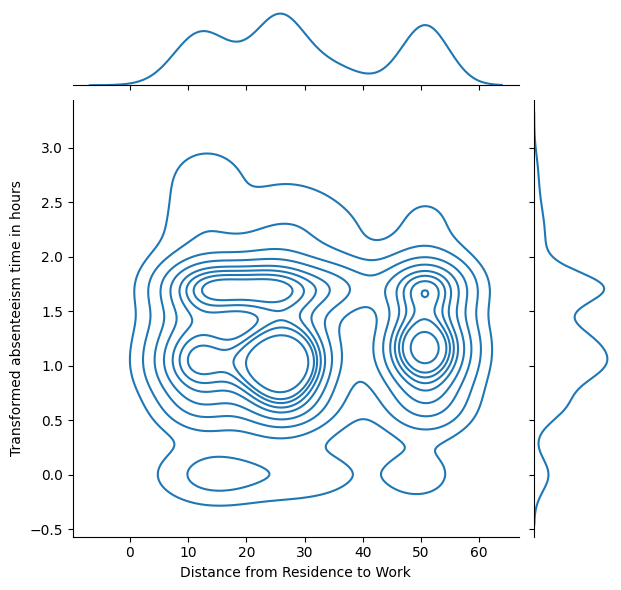

<Figure size 800x600 with 0 Axes>

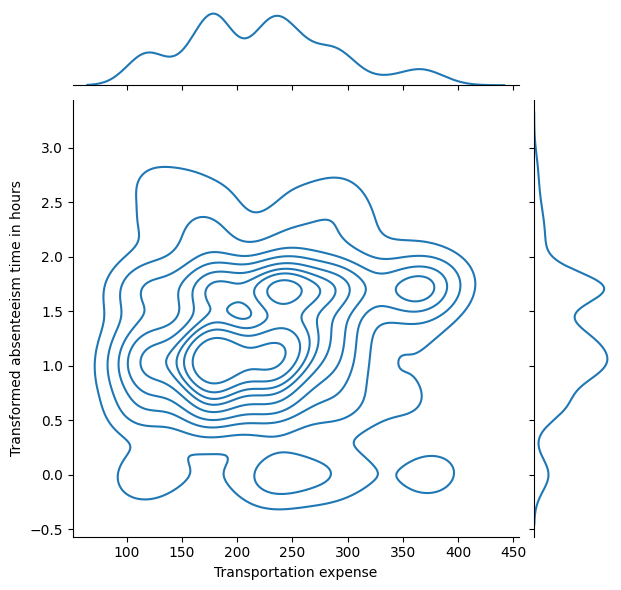

In [20]:
hours = yeojohnson(preprocessed_data["Absenteeism time in hours"].apply(float))

distance = preprocessed_data["Distance from Residence to Work"]
expenses = preprocessed_data["Transportation expense"]

plt.figure(figsize=(8,6))
ax=sns.jointplot(x=distance,y=hours[0],kind="reg")
ax.set_axis_labels("Distance from Residence to Work","Transformed abseentism in hours")
plt.show()

plt.figure(figsize=(8,6))
ax=sns.jointplot(x=expenses,y=hours[0],kind="reg")
ax.set_axis_labels("Transportation expense","Transformed abseentism in hours")
plt.show()

# produce KDE plots
plt.figure(figsize=(8, 6))
ax = sns.jointplot(x=distance, y=hours[0], kind="kde")
ax.set_axis_labels("Distance from Residence to Work","Transformed absenteeism time in hours")
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.jointplot(x=expenses, y=hours[0], kind="kde")
ax.set_axis_labels("Transportation expense",
                   "Transformed absenteeism time in hours")
plt.show()


<ipython-input-21-036c6191a652>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=preprocessed_data, x="Day of the week", order=["Monday", "Tuesday",


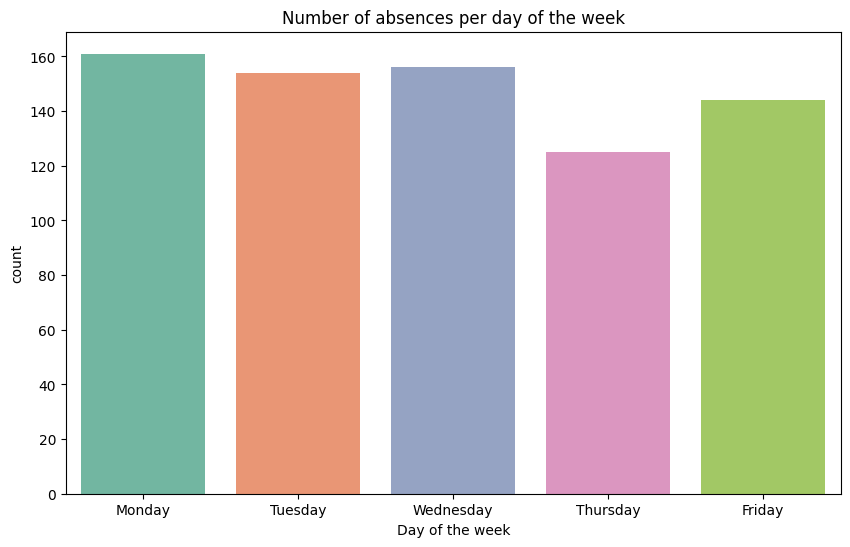

<ipython-input-21-036c6191a652>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=preprocessed_data,


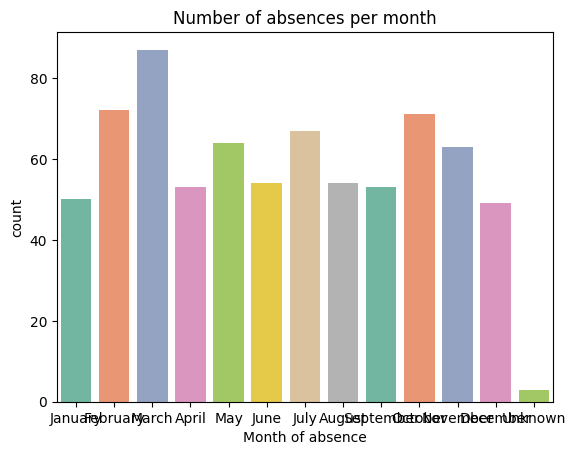

<ipython-input-21-036c6191a652>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=preprocessed_data, y="Absenteeism time in hours", x="Day of the week", order=["Monday", "Tuesday",


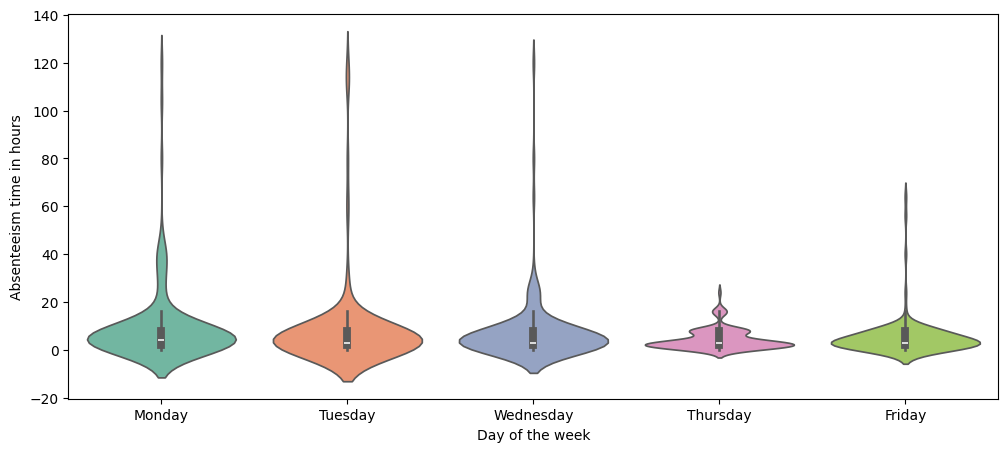

<ipython-input-21-036c6191a652>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=preprocessed_data, y="Absenteeism time in hours", x="Month of absence", order=["January", "February", "March",


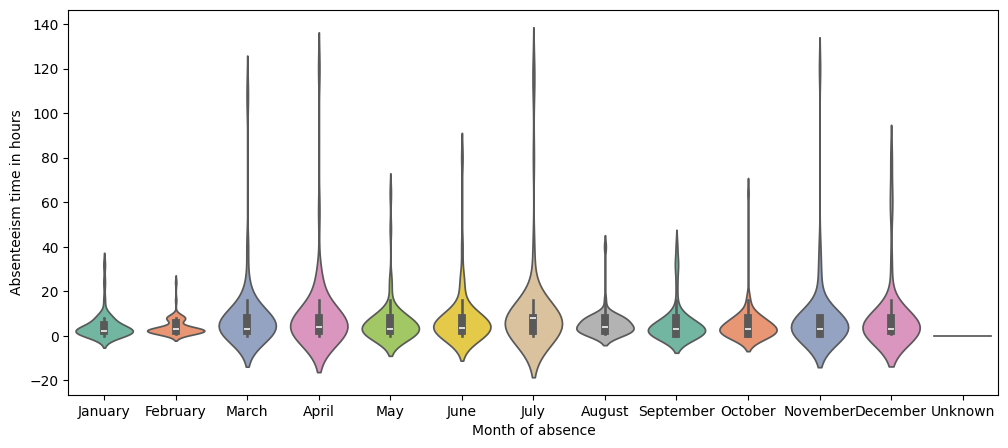

Day of the week: Monday     | Mean : 9.248 | Stddev: 15.973
Day of the week: Tuesday    | Mean : 7.981 | Stddev: 18.027
Day of the week: Wednesday  | Mean : 7.147 | Stddev: 13.268
Day of the week: Thursday   | Mean : 4.424 | Stddev: 4.266
Day of the week: Friday     | Mean : 5.125 | Stddev: 7.911
Months: January    | Mean :    4.440 | Stddev:    7.911
Months: February   | Mean :    4.083 | Stddev:    7.911
Months: March      | Mean :    8.793 | Stddev:    7.911
Months: April      | Mean :    9.094 | Stddev:    7.911
Months: May        | Mean :    6.250 | Stddev:    7.911
Months: June       | Mean :    7.611 | Stddev:    7.911
Months: July       | Mean :   10.955 | Stddev:    7.911
Months: August     | Mean :    5.333 | Stddev:    7.911
Months: September  | Mean :    5.509 | Stddev:    7.911
Months: October    | Mean :    4.915 | Stddev:    7.911
Months: November   | Mean :    7.508 | Stddev:    7.911
Months: December   | Mean :    8.449 | Stddev:    7.911
Months: Unknown    | Mean :   

In [21]:
# Temporal Factors - Day of the week and Month of absence
plt.figure(figsize=(10, 6))
sns.countplot(data=preprocessed_data, x="Day of the week", order=["Monday", "Tuesday",
                                                                  "Wednesday", "Thursday", "Friday"],palette="Set2")
plt.title("Number of absences per day of the week")
plt.show()

ax = sns.countplot(data=preprocessed_data,
                   x='Month of absence',
                   order=["January", "February", "March",
                          "April", "May", "June", "July",
                          "August", "September", "October",
                          "November", "December", "Unknown"], palette="Set2")
plt.title("Number of absences per month")
plt.show()

# Distribution of weeks and month for the abseentism in hours
plt.figure(figsize=(12,5))
sns.violinplot(data=preprocessed_data, y="Absenteeism time in hours", x="Day of the week", order=["Monday", "Tuesday",
                                                                                                  "Wednesday", "Thursday", "Friday"],palette="Set2")
plt.show()

plt.figure(figsize=(12,5))
sns.violinplot(data=preprocessed_data, y="Absenteeism time in hours", x="Month of absence", order=["January", "February", "March",
                                                                                                   "April", "May", "June", "July",
                                                                                                   "August", "September", "October",
                                                                                                   "November", "December", "Unknown"], palette="Set2")
plt.show()


dows = ["Monday", "Tuesday","Wednesday", "Thursday", "Friday"]
for dow in dows:
    mask = preprocessed_data["Day of the week"] == dow
    hours = preprocessed_data["Absenteeism time in hours"][mask]
    mean = hours.mean()
    std_dev = hours.std()
    print(f"Day of the week: {dow:10s} | Mean : {mean:.03f} | Stddev: {std_dev:.03f}")

months = ["January", "February", "March",
          "April", "May", "June", "July",
          "August", "September", "October",
          "November", "December", "Unknown"]

for mon in months:
    mask_month = preprocessed_data["Month of absence"] == mon
    month_abs = preprocessed_data["Absenteeism time in hours"][mask_month]
    mean = month_abs.mean()
    std_Dev = month_abs.std()
    print(f"Months: {mon:10s} | Mean : {mean:8.03f} | Stddev: {std_dev:8.03f}")


Based on the visualization and descriptive summary, we observe the shorter on thursday(4.4 hours) and july have longest average duration(10.995 hours), will check the statistical significant among thursday and july


In [22]:
thursday_mask = preprocessed_data["Day of the week"] == "Thursday"
july_mask = preprocessed_data["Month of absence"] == "July"
thursday_data = preprocessed_data["Absenteeism time in hours"][thursday_mask]
no_thursday_data = preprocessed_data["Absenteeism time in hours"][~thursday_mask]
july_data = preprocessed_data["Absenteeism time in hours"][july_mask]
no_july_data = preprocessed_data["Absenteeism time in hours"][~july_mask]

thu_res = ttest_ind(thursday_data,no_thursday_data)

july_res = ttest_ind(july_data,no_july_data)
print(f"Thursday test result: statistic={thu_res[0]:.3f}, pvalue={thu_res[1]:.3f}")
print(f"July test result: statistic={july_res[0]:.3f}, pvalue={july_res[1]:.3f}")

print(preprocessed_data.head().T)

Thursday test result: statistic=-2.307, pvalue=0.021
July test result: statistic=2.605, pvalue=0.009
                                           0            1            2  \
ID                                        11           36            3   
Reason for absence                        26            0           23   
Month of absence                        July         July         July   
Day of the week                      Tuesday      Tuesday    Wednesday   
Seasons                               Spring       Spring       Spring   
Transportation expense                   289          118          179   
Distance from Residence to Work           36           13           51   
Service time                              13           18           18   
Age                                       33           50           38   
Work load Average/day                239.554      239.554      239.554   
Hit target                                97           97           97   
Disciplinar

 We can conclude, since both p-values are lower, there is a stastical significant difference available :

Statistical significant difference between thruday and other days

Absence in july are longer over the year, we can reject the null hypothesis of having no difference
